In [1]:
from imp import reload
import sys
#print(sys.version)
# import rpy2
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
pd.show_versions()
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = False
# Use Type 1 fonts in plots.
matplotlib.rc('pdf', fonttype=42)
matplotlib.rcParams['font.size'] = 18
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.8.0-41-generic
Version          : #46~20.04.1-Ubuntu SMP Mon Jan 18 17:52:23 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_GB.UTF-8
LOCALE           : en_GB.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : 3.0a6
pytest           : 4.6.9
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
f

# Asteroid Route Optimization


In [2]:
#dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
    instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
    sol = dfbest[dfbest.instance_name==instance_name]
    if len(sol) != 1: 
        print("No opt value")
        return np.nan
    if sol.best_known_subdiagonal.isna().bool():
        return sol.best_known.iloc[0]
    else:
        return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        tmp = pd.read_csv(filename)
        print(filename)
        #tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        tmp.instance = 'ARP_'+ tmp.instance
        if "dist_hamming" in filename:
            tmp['Distance'] = "hamming"
        elif "dist_kendall" in filename:
            tmp['Distance'] = "kendall"
        if "umm2" in filename:
             tmp['Solver'] = "UMM2"
        if "-er0" in filename:
            tmp['Solver'] += "_order"
        elif "-er1" in filename:
            tmp['Solver'] += "_rank"
        tmp['Solver'] += '_'
        tmp['Solver'] += tmp.budget.astype(str)
        lis.append(tmp)
    return pd.concat(lis, sort = True)

def check_runs(df, nruns):
    df2 = df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].sum()
    totalruns = np.arange(1, nruns + 1).sum()
    assert (df2 == totalruns).all(),f"{df2[df2 != totalruns]}"
    assert (df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == nruns).all()

# If runs were terminated after different number of evaluations, 
# use only the evaluations reached in all runs to avoid misleading mean and variance.
def filter_unequal_budget(df, budget):
    groups = ['Solver','instance','eval_ranks','Distance']
    df_max_evals = df[df.Solver.str.startswith("CEGO")].groupby(groups + ['seed'])['Function evaluations'].max()
    df_max_evals = df_max_evals.groupby(groups).min()
    for index,row  in df_max_evals.reset_index().iterrows():
        if row['Function evaluations'] == budget: continue
        before = df.shape[0]
        # FIXME: How to do this in a shorter manner?
        df = df[~((df.Solver == row.Solver) & (df.instance == row.instance) & (df.eval_ranks == row.eval_ranks) & (df.Distance == row.Distance) & (df['Function evaluations'] > row['Function evaluations']))]
        print(f"Removed {before - df.shape[0]} rows for Solver={row.Solver} instance={row.instance} eval_ranks={row.eval_ranks} Distance={row.Distance}")
    return df

df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
# These are the instances used in the paper
sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02',
             'lop/RandB/N-p40-01','lop/RandB/N-p40-02' ,'lop/RandB/N-p50-02', 'lop/RandB/N-p50-01',
             'pfsp_cmax/rec05.txt','pfsp_cmax/rec13.txt', 'pfsp_cmax/rec19.txt',  'pfsp_cmax/rec31.txt']
sel_insts = None
if sel_insts:
    df = df[(mask) & (df.instance.isin(sel_insts))]
else:
    sel_insts = np.sort(df.instance.unique())
nruns = 5
df = filter_unequal_budget(df, 1000)
# Checks that make sure we have the correct number of runs
check_runs(df, nruns)

./results/m200-er1/arp_15_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_15_42/cego.csv.xz
./results/m200-er1/arp_20_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_20_42/cego.csv.xz
./results/m200-er1/arp_10_42/umm-maxmindist.csv.xz
./results/m200-er1/arp_10_42/cego.csv.xz
./results/m100-er0/arp_15_42/umm-maxmindist.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist-r1.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist-r3.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist-r4.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist-r5.csv.xz
./results/m100-er0/arp_15_42/umm2-maxmindist-r2.csv.xz
./results/m100-er0/arp_15_42/cego.csv.xz
./results/m100-er0/arp_20_42/umm-maxmindist.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist-r1.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist-r3.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist-r4.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist-r5.csv.xz
./results/m100-er0/arp_20_42/umm2-maxmindist-r2.csv.xz
./results/m100-er0/arp_20_42/ce

In [3]:
df

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,eval_ranks,init,instance,m_ini,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x
0,NaN,900.796780,1,ARP,UMM_rank_200,200,NaN,1,maxmindist,ARP_15_42,10,NaN,NaN,0.1,NaN,945.397691,1,0.9,3 7 6 2 10 4 1 13 0 14 9 8 12 11 5
1,NaN,727.040668,2,ARP,UMM_rank_200,200,NaN,1,maxmindist,ARP_15_42,10,NaN,NaN,0.1,NaN,945.397691,1,0.9,7 4 11 8 5 10 12 1 14 3 2 9 0 6 13
2,NaN,745.790792,3,ARP,UMM_rank_200,200,NaN,1,maxmindist,ARP_15_42,10,NaN,NaN,0.1,NaN,945.397691,1,0.9,9 4 0 10 7 1 12 6 11 5 14 8 13 2 3
3,NaN,837.758678,4,ARP,UMM_rank_200,200,NaN,1,maxmindist,ARP_15_42,10,NaN,NaN,0.1,NaN,945.397691,1,0.9,14 13 11 8 5 12 7 0 1 3 6 4 10 9 2
4,NaN,768.538114,5,ARP,UMM_rank_200,200,NaN,1,maxmindist,ARP_15_42,10,NaN,NaN,0.1,NaN,945.397691,1,0.9,7 12 10 3 8 6 13 14 11 9 5 0 2 4 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,500.020966,496,ARP,UMM_order_500,500,NaN,0,maxmindist,ARP_10_42,10,NaN,0.125,0.1,4.365575e-11,1872.114282,5,0.9,1 8 6 5 4 9 7 3 0 2
2496,NaN,516.804062,497,ARP,UMM_order_500,500,NaN,0,maxmindist,ARP_10_42,10,NaN,0.125,0.1,4.365575e-11,1872.114282,5,0.9,1 7 5 9 3 8 6 4 2 0
2497,NaN,395.488082,498,ARP,UMM_order_500,500,NaN,0,maxmindist,ARP_10_42,10,NaN,0.125,0.1,4.365575e-11,1872.114282,5,0.9,0 8 4 9 5 7 6 3 1 2
2498,NaN,412.447898,499,ARP,UMM_order_500,500,NaN,0,maxmindist,ARP_10_42,10,NaN,0.125,0.1,5.093170e-11,1872.114282,5,0.9,1 7 4 8 5 9 6 3 0 2


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', None,'display.max_colwidth', -1):
    print(df.groupby(["Solver","instance"])['seed'].unique())
    print(df.groupby(["Solver","instance"])['seed'].sum())

Solver          instance 
CEGO_order_100  ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    [1, 2, 3, 4, 5]
CEGO_order_200  ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    [1, 2, 3, 4, 5]
CEGO_rank_100   ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    [1, 2, 3, 4, 5]
CEGO_rank_200   ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    [1, 2, 3, 4, 5]
UMM2_order_100  ARP_10_42    [1, 3, 4, 5, 2]
                ARP_15_42    [1, 3, 4, 5, 2]
                ARP_20_42    [1, 3, 4, 5, 2]
UMM2_rank_100   ARP_10_42    [1]            
UMM_order_100   ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    [1, 2, 3, 4, 5]
UMM_order_1000  ARP_10_42    [1, 2, 3, 4, 5]
                ARP_15_42    [1, 2, 3, 4, 5]
                ARP_20_42    

## Plot results
Plot the fitness along iteration of the instances in the paper, LOP and PFSP

instance:  ARP_15_42
Solver          eval_ranks  budget
CEGO_order_100  0           100        500
CEGO_order_200  0           200       1000
UMM2_order_100  0           100       1000
UMM_order_100   0           100        500
UMM_order_1000  0           1000      5000
UMM_order_200   0           200       1000
UMM_order_500   0           500       2500
dtype: int64


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


Saving to img/fitness_ARP_15_42.pdf


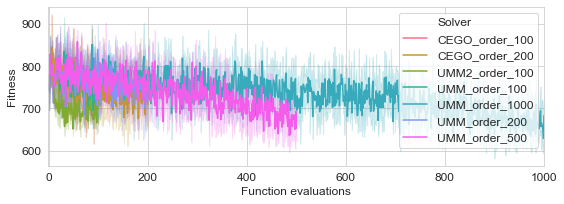

instance:  ARP_15_42
Solver         eval_ranks  budget
CEGO_rank_100  1           100        500
CEGO_rank_200  1           200       1000
UMM_rank_100   1           100        500
UMM_rank_1000  1           1000      5000
UMM_rank_200   1           200       1000
UMM_rank_500   1           500       2500
dtype: int64
Saving to img/fitness_ARP_15_42.pdf


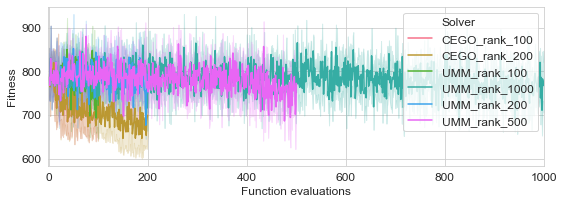

instance:  ARP_20_42
Solver          eval_ranks  budget
CEGO_order_100  0           100        500
CEGO_order_200  0           200       1000
UMM2_order_100  0           100       1000
UMM_order_100   0           100        500
UMM_order_1000  0           1000      5000
UMM_order_200   0           200       1000
UMM_order_500   0           500       2500
dtype: int64
Saving to img/fitness_ARP_20_42.pdf


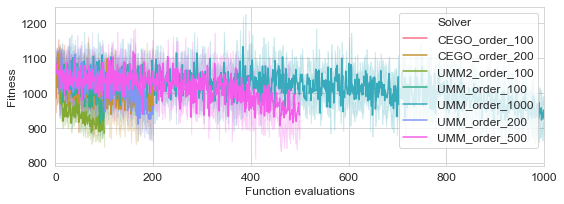

instance:  ARP_20_42
Solver         eval_ranks  budget
CEGO_rank_100  1           100        500
CEGO_rank_200  1           200       1000
UMM_rank_100   1           100        500
UMM_rank_1000  1           1000      5000
UMM_rank_200   1           200       1000
UMM_rank_500   1           500       2500
dtype: int64
Saving to img/fitness_ARP_20_42.pdf


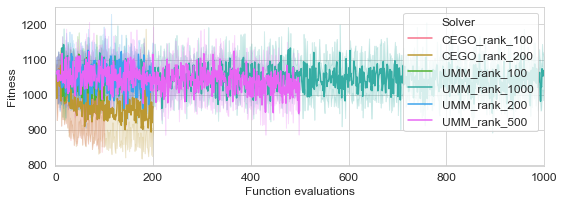

instance:  ARP_10_42
Solver          eval_ranks  budget
CEGO_order_100  0           100        500
CEGO_order_200  0           200       1000
UMM2_order_100  0           100       1000
UMM_order_100   0           100        500
UMM_order_1000  0           1000      5000
UMM_order_200   0           200       1000
UMM_order_500   0           500       2500
dtype: int64
Saving to img/fitness_ARP_10_42.pdf


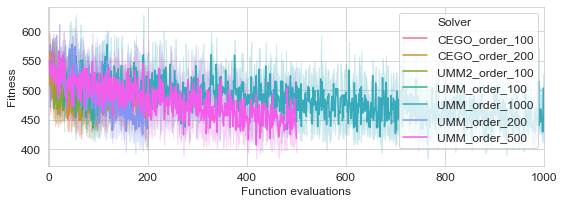

instance:  ARP_10_42
Solver         eval_ranks  budget
CEGO_rank_100  1           100        500
CEGO_rank_200  1           200       1000
UMM2_rank_100  1           100        100
UMM_rank_100   1           100        500
UMM_rank_1000  1           1000      5000
UMM_rank_200   1           200       1000
UMM_rank_500   1           500       2500
dtype: int64
Saving to img/fitness_ARP_10_42.pdf


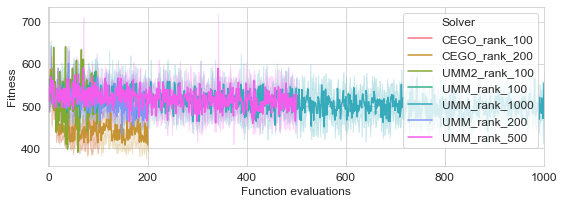

In [5]:
def plot_fitness(df, inst):
    subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
    print("instance: ", inst)
    print(subdf.groupby(['Solver', 'eval_ranks','budget' ]).size())
    if len(subdf) == 0: return
    plt.figure(figsize=(8,3))
    val_opt = None #get_opt(inst)
    budget = subdf.budget.max()
    if val_opt is not None: 
        print("optimum: ", val_opt)
        plt.plot([0,budget],[val_opt,val_opt])
    palette = sns.color_palette("husl", subdf['Solver'].nunique())
    g = sns.lineplot(x='Function evaluations', y='Fitness', hue='Solver', data=subdf, palette=palette)
    g.set(xlim=(-1, budget+1))
    plt.tight_layout()
    filename = 'img/fitness_' + subdf.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()  

matplotlib.rcParams['font.size'] = 12
sel_insts = df.instance.unique()
for inst in sel_insts:
    for _, gdf in df.groupby('eval_ranks'):
        plot_fitness(gdf, inst)
        

## Summary table of the results

Table with the summary of the results

In [6]:
sel_confs = ['CEGO_rank_200', 'UMM_order_200']
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime['Instance'] = [i[-1] for i in dftime.instance.str.split('/').values]
dftime['Instance'] = dftime['Instance'].str.replace('.txt','').str.replace('.dat', '')
dftime = dftime.drop('instance',axis=1)
dftime = dftime[['Problem', 'Instance'] + sel_confs]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Problem &  Instance &  CEGO\_rank\_200 &  UMM\_order\_200 \\
\midrule
    ARP & ARP\_10\_42 &         405.10 &          11.70 \\
    ARP & ARP\_15\_42 &         483.86 &          16.94 \\
    ARP & ARP\_20\_42 &         384.36 &          17.48 \\
\bottomrule
\end{tabular}



<ipython-input-6-ad1b4b2d47ec>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  dftime['Instance'] = dftime['Instance'].str.replace('.txt','').str.replace('.dat', '')


In [7]:
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=[ 'Problem', 'instance'],columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b!='' else a for (a,b)  in df_fitness.columns]
df_fitness['Instance'] = [i[-1] for i in df_fitness.instance.str.split('/').values]
df_fitness['Instance'] = df_fitness['Instance'].str.replace('.txt','').str.replace('.dat', '')
df_fitness = df_fitness.drop('instance',axis=1)
df_fitness = df_fitness[['Problem', 'Instance'] + sel_confs]
df_fitness
print(df_fitness.to_latex(index=False))


\begin{tabular}{llrr}
\toprule
Problem &  Instance &  CEGO\_rank\_200 &  UMM\_order\_200 \\
\midrule
    ARP & ARP\_10\_42 &     371.876906 &     389.962440 \\
    ARP & ARP\_15\_42 &     611.962470 &     619.496389 \\
    ARP & ARP\_20\_42 &     834.071417 &     857.500056 \\
\bottomrule
\end{tabular}



<ipython-input-7-5710ac9d7f52>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fitness['Instance'] = df_fitness['Instance'].str.replace('.txt','').str.replace('.dat', '')


In [8]:
# Keep only one CEGO and one UMM
df = df[df.Solver.isin(['CEGO_inv','UMM_400'])]
# Make sure we have the right data
mask = ((df.budget==400) & (df.eval_ranks==0)&((df.budgetMM == 1) | (df.budgetMM.isna())))
df = df[mask]
df.Solver = df.Solver.str.replace('CEGO_inv','CEGO').str.replace('UMM_400', 'UMM')

# The maximum time per seed and evaluation is the final time.
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = df[df.Solver == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
# Fix instance names
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df['Instance'] = df['Instance'].str.replace('.txt','').str.replace('.dat', '')
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

AttributeError: 'DataFrame' object has no attribute 'budgetMM'

In [ ]:
print(df.to_latex(index=False))